In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
pd.set_option("display.max_columns", 200)
from sklearn.metrics import r2_score

df = pd.read_csv('ListingsAndSales.csv')
#not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull(), 'NotSoldFlag'] = 1

print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate = pd.to_datetime(df.ListingDate)

df.SalesDate = pd.to_datetime(df.SalesDate)
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

#Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

#calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

#loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']
for col in df.columns:
    if not col in col_dates:
        if df[col].isnull().sum(axis=0) > 0:
            df[col + "_mv"] = (df[col].isnull())
            col_avg = df.loc[df[col].isnull() == False, col].mean()
            df[col] = df[col].fillna(col_avg)

#Columns to use as regressor
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

#Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X), columns=X.columns).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)

#For numeric stability
EPSILON = 1e-10

class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)

    def train(self, X, Y, sold, epochs):
        sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        sess.run(tf.global_variables_initializer())
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]
        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []
        bs = 64
        num_batches = (trn_samples // bs) + 1
        for epoch in range(epochs):
            trn_loss = []
            order = np.arange(trn_samples)
            np.random.shuffle(order)
            for itr in range(trn_samples // bs):
                rows = order[itr * bs:(itr + 1) * bs]
                if itr + 1 == num_batches:
                    rows = order[itr * bs:]
                X_active, Y_active, Sold_active = X_train[rows, :], Y_train[
                    rows], sold_train[rows]
                feed_dict = {
                    self.x: X_active,
                    self.y: Y_active,
                    self.sold: Sold_active
                }
                _, loss, yhat = sess.run(
                    [self.optimizer, self.loss, self.output], feed_dict)
                trn_loss.append(loss)
            if epoch % 2 == 0:
                trn_loss_mean = np.mean(trn_loss)
                self.trn_losses.append(trn_loss_mean)
                feed_dict = {
                    self.x: X_test,
                    self.y: Y_test,
                    self.sold: sold_test
                }
                val_loss, yhat = sess.run([self.loss, self.output], feed_dict)
                self.val_losses.append(val_loss)
                self.r2_scores.append(r2_score(Y_test, yhat))
            if epoch % 10 == 0:
                print('epoch:', epoch, 'train loss: ', trn_loss_mean,
                      'val loss: ', val_loss, 'r2_score:', self.r2_scores[-1])

    def visualize(self, name):
        plt.plot(self.trn_losses, label='train loss')
        plt.plot(self.val_losses, label='test loss')
        plt.title('least square losses')
        plt.legend()
        plt.savefig(name + 'losses.jpg')
        plt.show()
        plt.plot(self.r2_scores, label='validation r2_scores')
        plt.legend()
        plt.title('r2 scores')
        plt.savefig(name + 'r2scores.jpg')
        plt.show()


n_features = X.shape[1]


C:\Users\leedt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


percent not yet sold: 0.6864035087719298


epoch: 0 train loss:  738.57056 val loss:  666.7412 r2_score: -0.026767153787945697
epoch: 10 train loss:  670.02966 val loss:  608.355 r2_score: 0.05768632358518344
epoch: 20 train loss:  597.4744 val loss:  543.2073 r2_score: 0.15075104077418766
epoch: 30 train loss:  534.6189 val loss:  487.52557 r2_score: 0.23026494123106622
epoch: 40 train loss:  480.0936 val loss:  443.05362 r2_score: 0.294498732113178
epoch: 50 train loss:  437.10992 val loss:  408.67258 r2_score: 0.34660942337622613
epoch: 60 train loss:  404.2587 val loss:  380.32947 r2_score: 0.3892722462869729
epoch: 70 train loss:  374.7957 val loss:  357.75098 r2_score: 0.4238411322602972
epoch: 80 train loss:  350.7631 val loss:  338.8819 r2_score: 0.4518383142569463
epoch: 90 train loss:  334.49667 val loss:  323.73508 r2_score: 0.4744391062048716


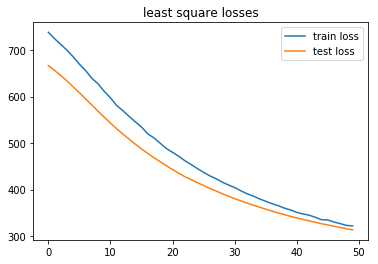

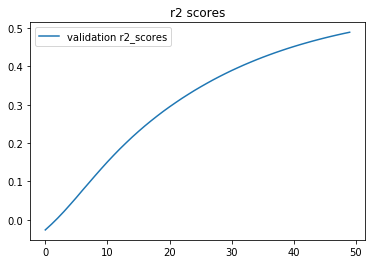

In [2]:

model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')


epoch: 0 train loss:  721.2586 val loss:  655.3073 r2_score: -0.005927121849325756
epoch: 10 train loss:  218.74089 val loss:  210.11124 r2_score: 0.6398090837229415
epoch: 20 train loss:  191.8271 val loss:  185.22725 r2_score: 0.6734010304460163
epoch: 30 train loss:  181.05058 val loss:  172.72528 r2_score: 0.6902803027760875
epoch: 40 train loss:  175.73146 val loss:  168.1656 r2_score: 0.6959966964971256
epoch: 50 train loss:  173.39378 val loss:  166.38068 r2_score: 0.6985905388969711
epoch: 60 train loss:  171.0941 val loss:  165.76382 r2_score: 0.7008191332882365
epoch: 70 train loss:  171.93541 val loss:  163.28954 r2_score: 0.703404497545526
epoch: 80 train loss:  171.5941 val loss:  162.94197 r2_score: 0.7042524878567897
epoch: 90 train loss:  170.2469 val loss:  164.56049 r2_score: 0.7047723075302778


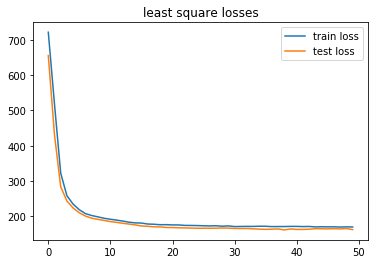

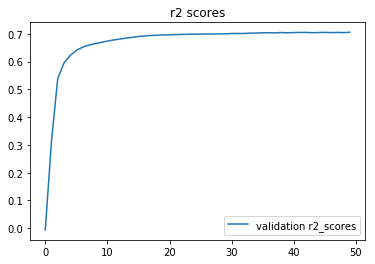

In [3]:

model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')


epoch: 0 train loss:  623.81305 val loss:  489.06378 r2_score: 0.27670812119164556
epoch: 10 train loss:  174.56197 val loss:  186.57222 r2_score: 0.6858526178992868
epoch: 20 train loss:  167.8094 val loss:  182.55267 r2_score: 0.6929410616062419
epoch: 30 train loss:  165.39124 val loss:  180.61832 r2_score: 0.6969304619010979
epoch: 40 train loss:  165.74785 val loss:  178.73984 r2_score: 0.7013140484351685
epoch: 50 train loss:  163.28154 val loss:  174.59805 r2_score: 0.7045157142913934
epoch: 60 train loss:  162.43546 val loss:  174.87228 r2_score: 0.7060642466382732
epoch: 70 train loss:  160.31978 val loss:  172.7968 r2_score: 0.7086559602984617
epoch: 80 train loss:  159.04175 val loss:  167.61552 r2_score: 0.7111626878988903
epoch: 90 train loss:  158.1476 val loss:  174.56715 r2_score: 0.7091283588307558


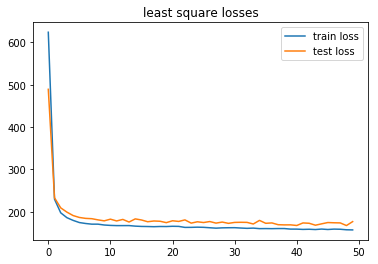

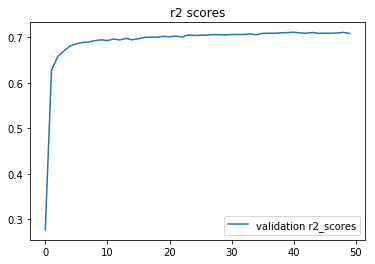

In [4]:

model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('two_hidden_layers')
